In [1]:
import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from common import CityResult
from file_name_generator import generate_new_name


Загрузка данных

In [2]:
mypath = './clusters_results/paris_variation'

In [3]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

Обработка данных

In [4]:
def theory_func(x, c, g, N = 9574, b0 = 1):
    x = x * c
    q = np.log(x) / np.log(N)
    return g / (x / b0 * (1 + q) + 1 / (2 * np.sqrt(x * N)) * (1 - q))

In [5]:
X_a = {}
Y_err = {}
Y_err_std = {}

Y_speedup = {}

for name in r:
    result: CityResult = r[name]
    X_a[name] = [a.alpha for a in result.points_results]
    Y_err[name] = [np.mean(a.errors) for a in result.points_results]
    Y_err_std[name] = [np.std(a.errors) for a in result.points_results]
    Y_speedup[name] = [np.mean(a.speed_up) for a in result.points_results]

Графики:

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_25532\4279320480.py:3: RuntimeWarning: divide by zero encountered in log
  q = np.log(x) / np.log(N)
C:\Users\Dmitry\AppData\Local\Temp\ipykernel_25532\4279320480.py:4: RuntimeWarning: invalid value encountered in multiply
  return g / (x / b0 * (1 + q) + 1 / (2 * np.sqrt(x * N)) * (1 - q))
C:\Users\Dmitry\AppData\Local\Temp\ipykernel_25532\4279320480.py:4: RuntimeWarning: divide by zero encountered in divide
  return g / (x / b0 * (1 + q) + 1 / (2 * np.sqrt(x * N)) * (1 - q))


c=0.00 b=4.71
c=0.01 b=4.28
c=0.01 b=4.12
c=0.01 b=3.86
c=0.01 b=3.96
c=0.01 b=3.85
c=0.01 b=3.67
c=0.01 b=3.85
c=0.01 b=3.66
c=0.01 b=3.76
c=0.01 b=3.77
c=0.01 b=3.65
c=0.01 b=3.59
c=0.01 b=3.66
c=0.01 b=3.43
c=0.01 b=3.49
c=0.01 b=3.35
c=0.01 b=3.73
c=0.01 b=3.31


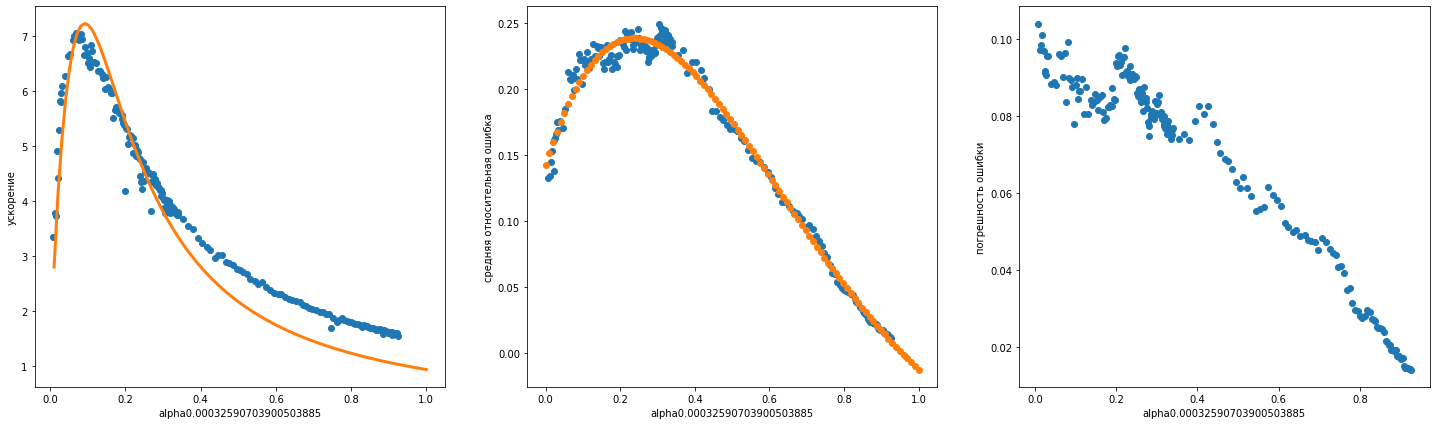

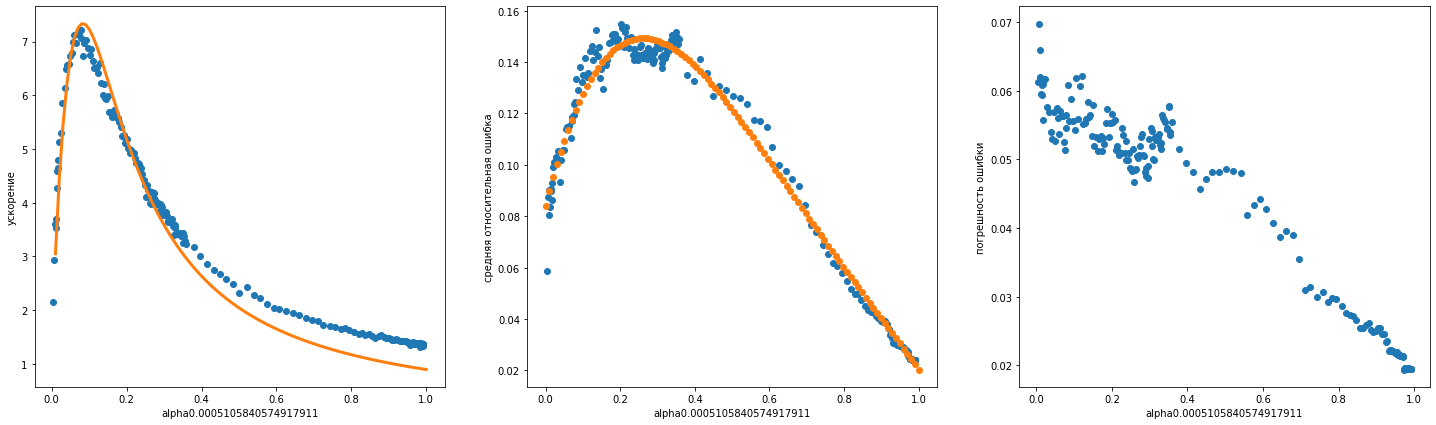

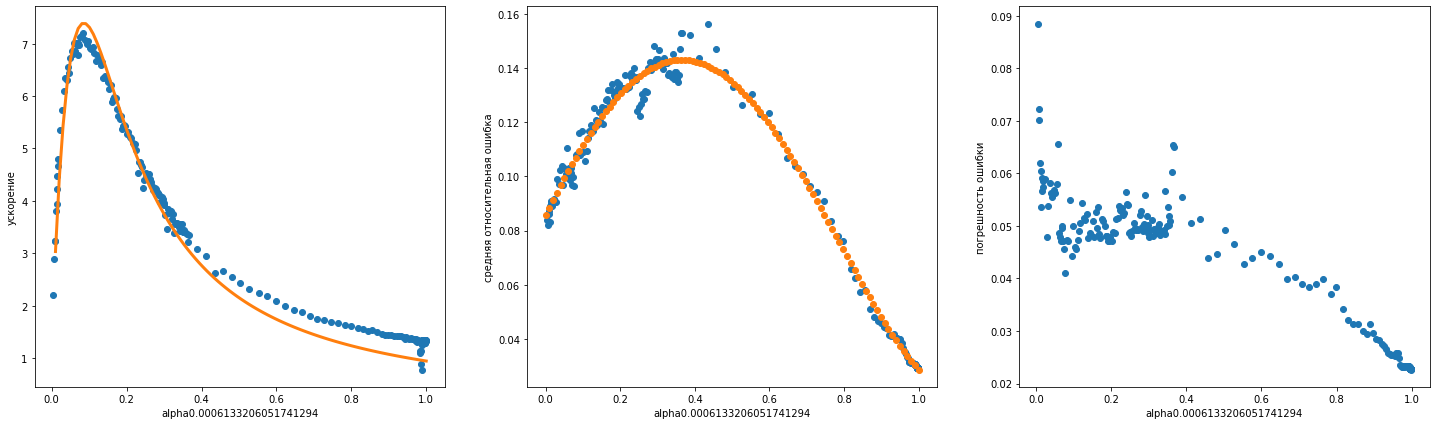

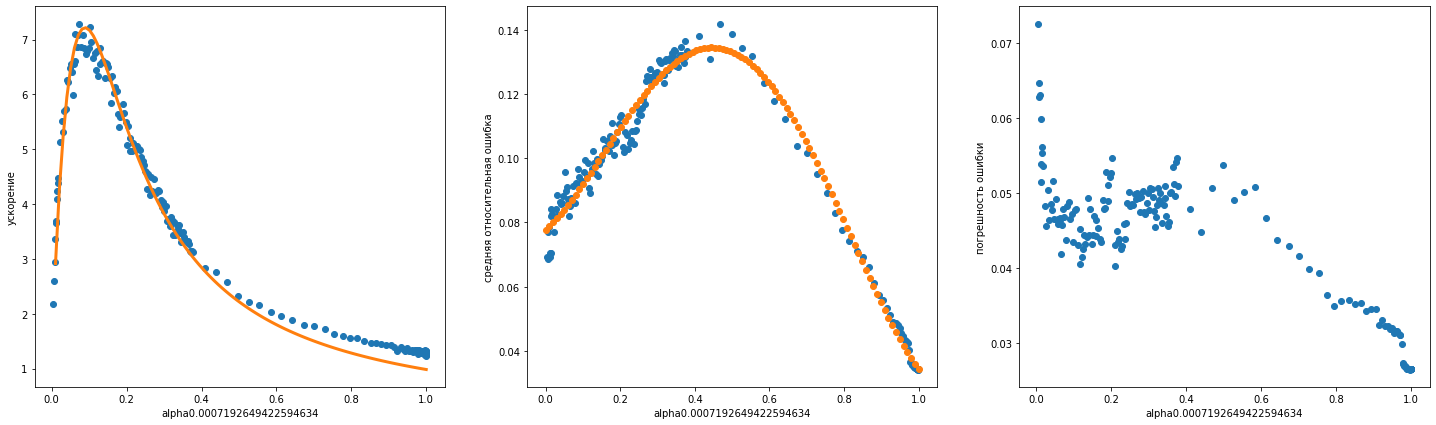

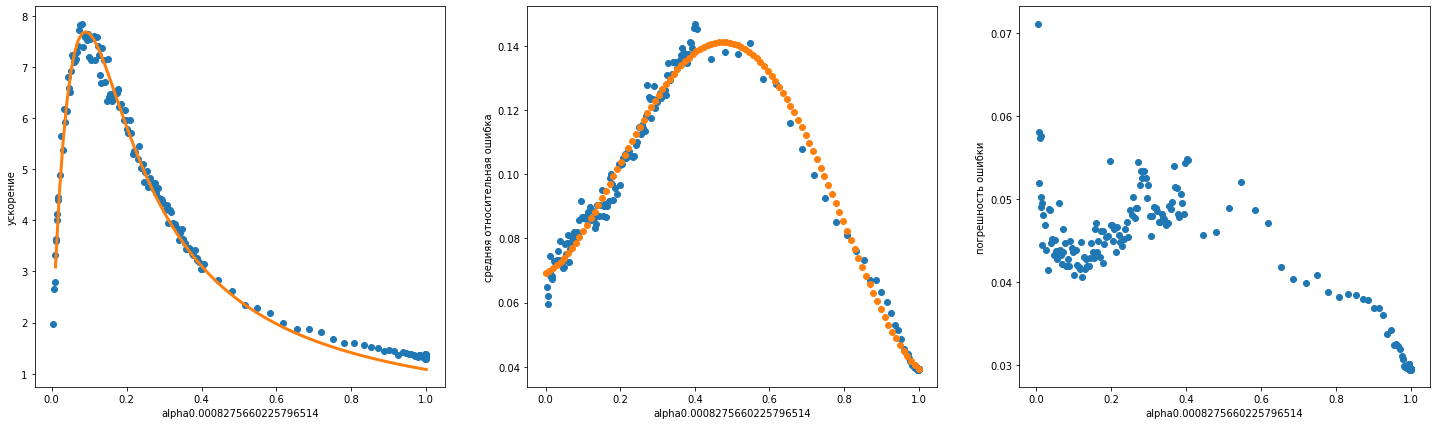

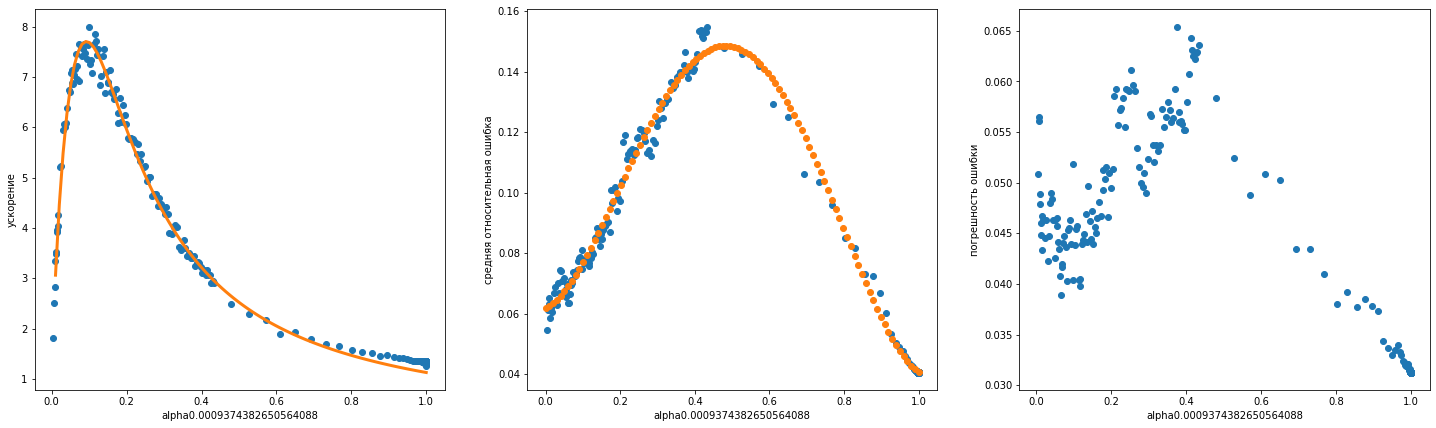

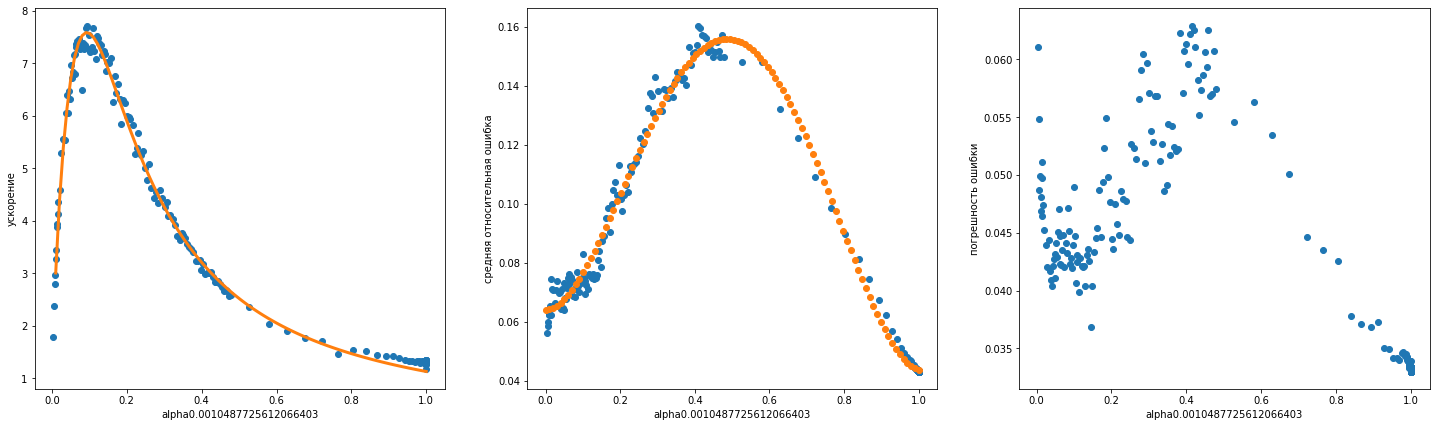

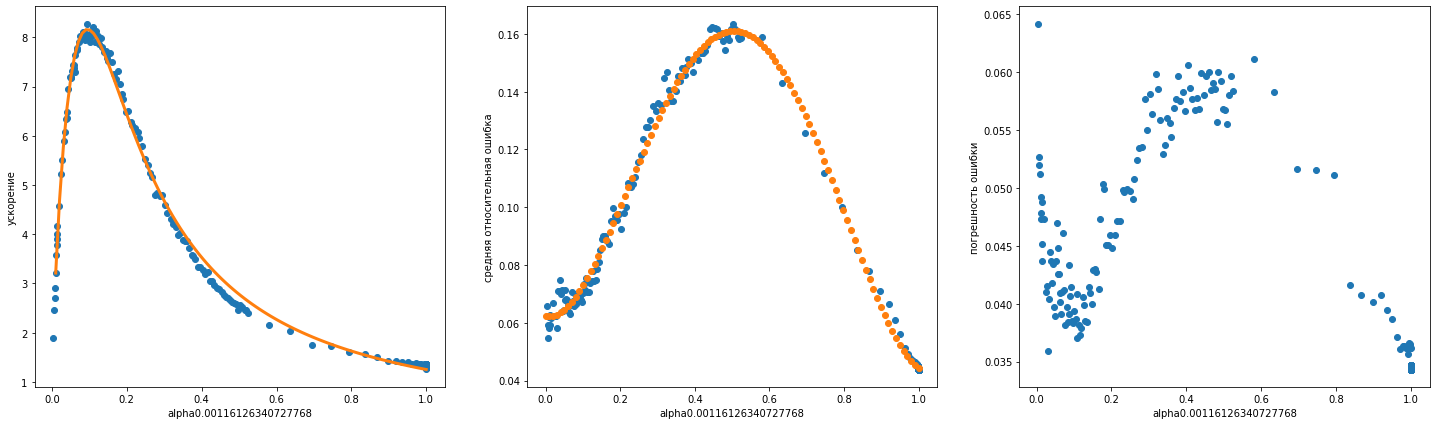

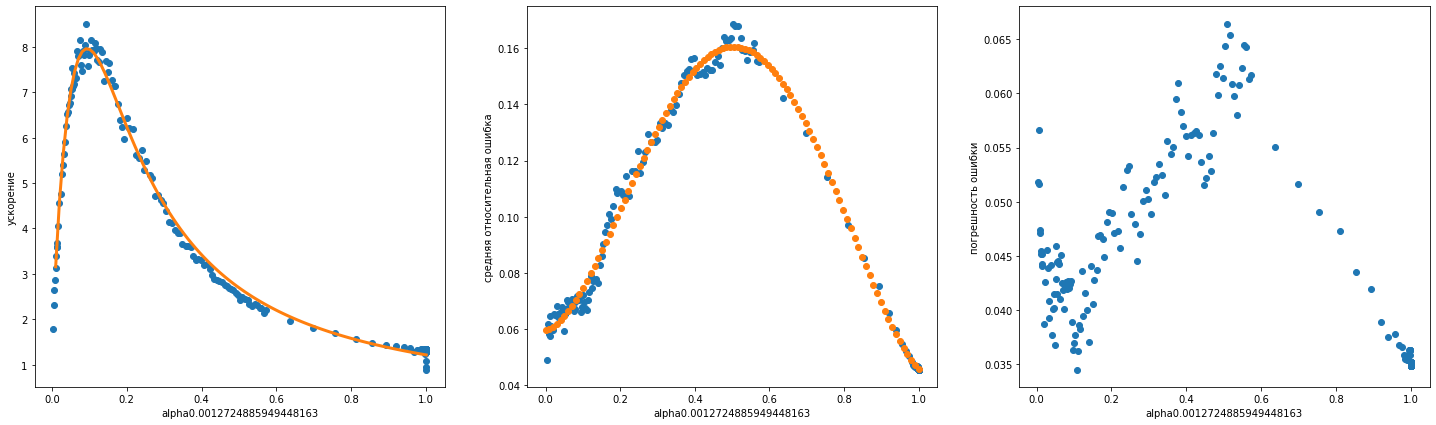

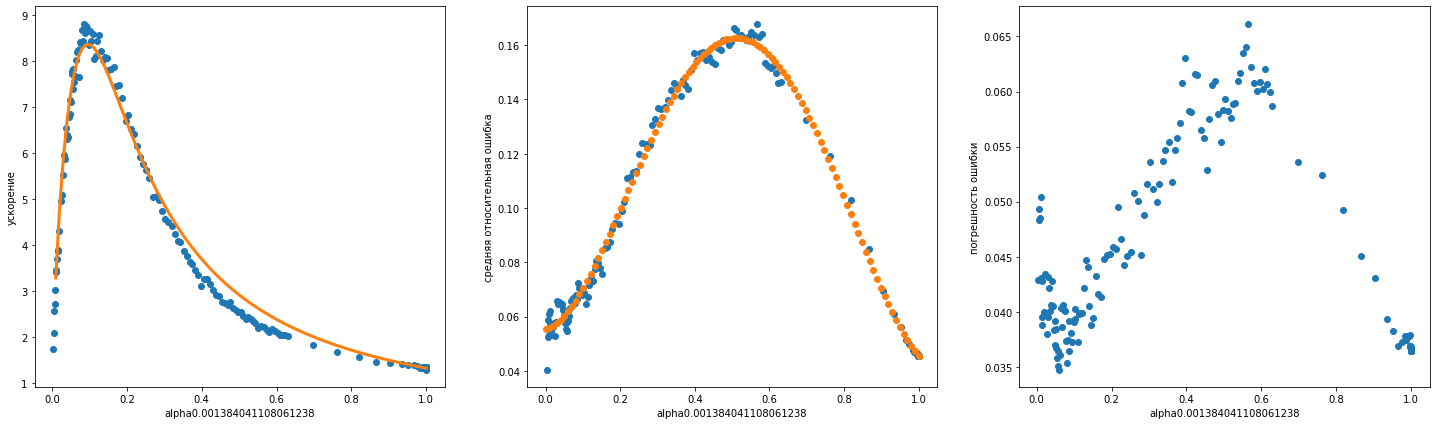

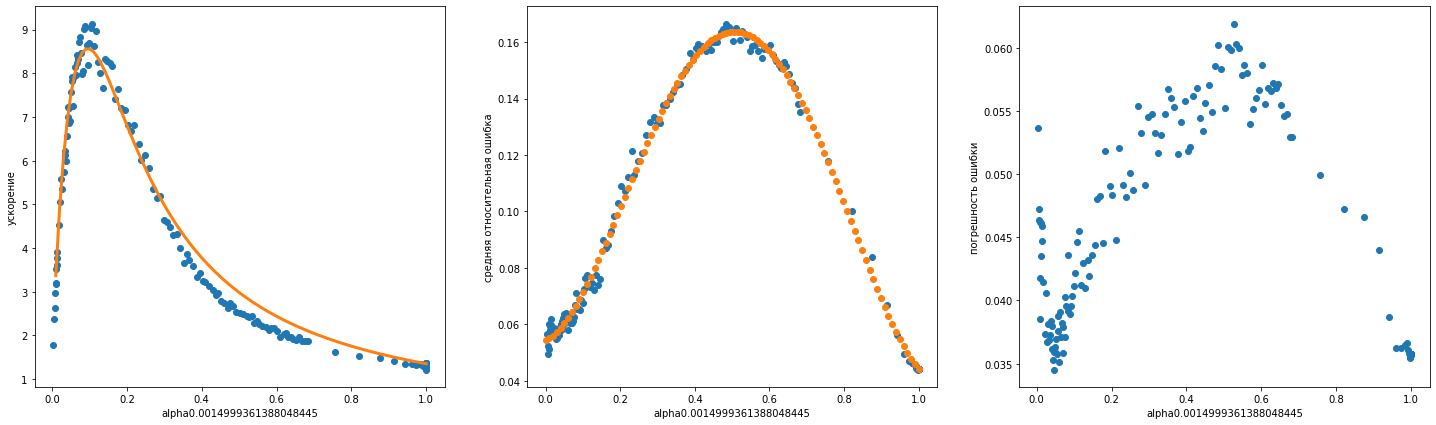

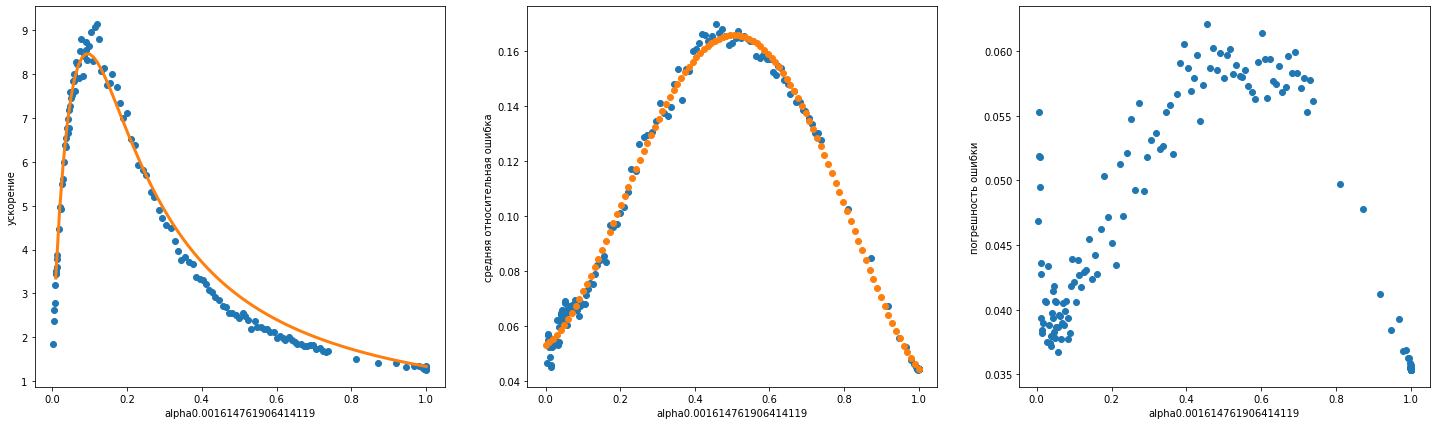

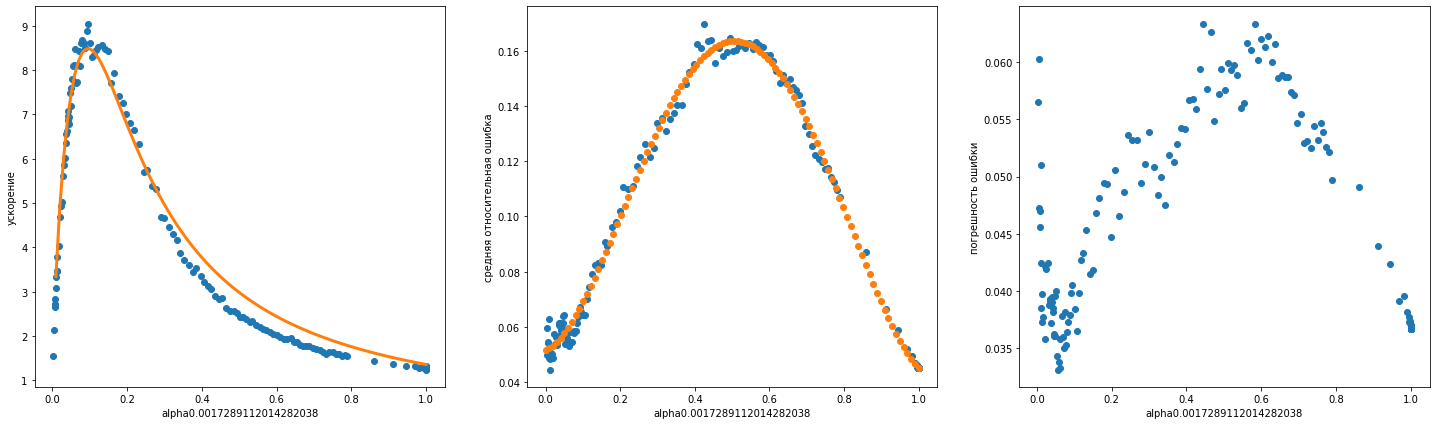

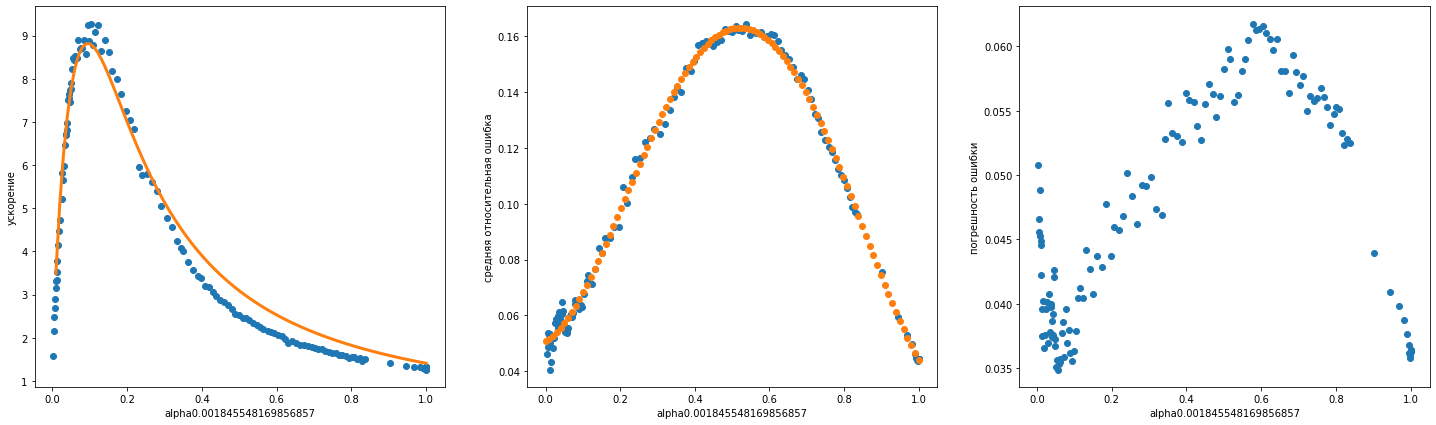

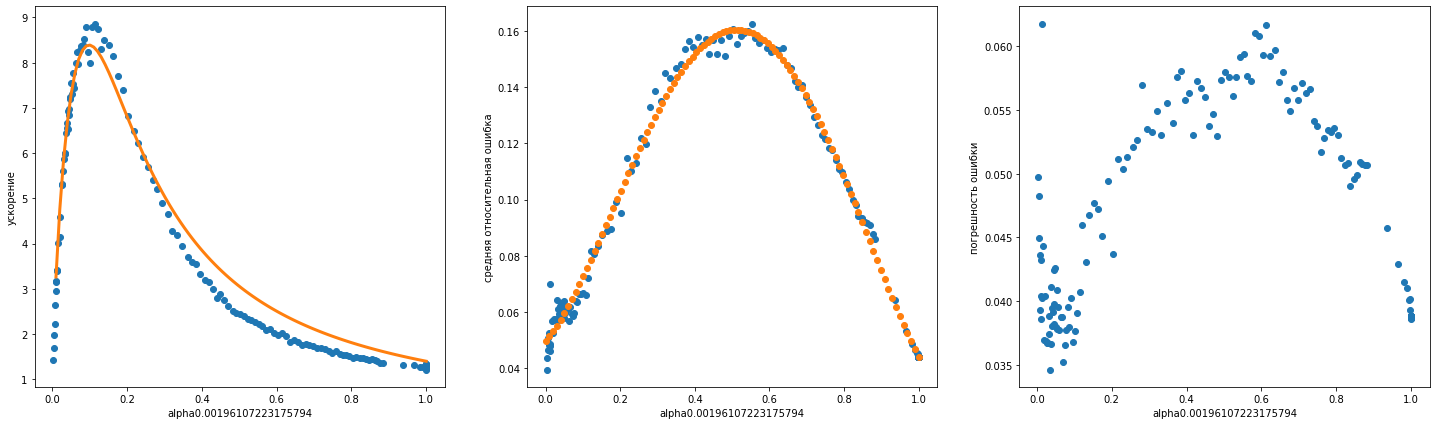

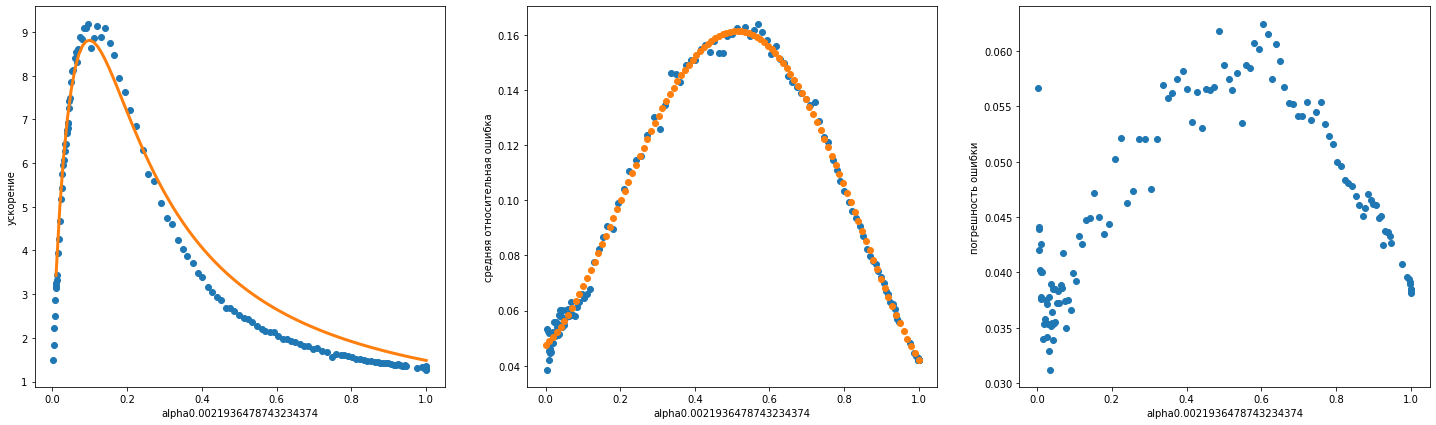

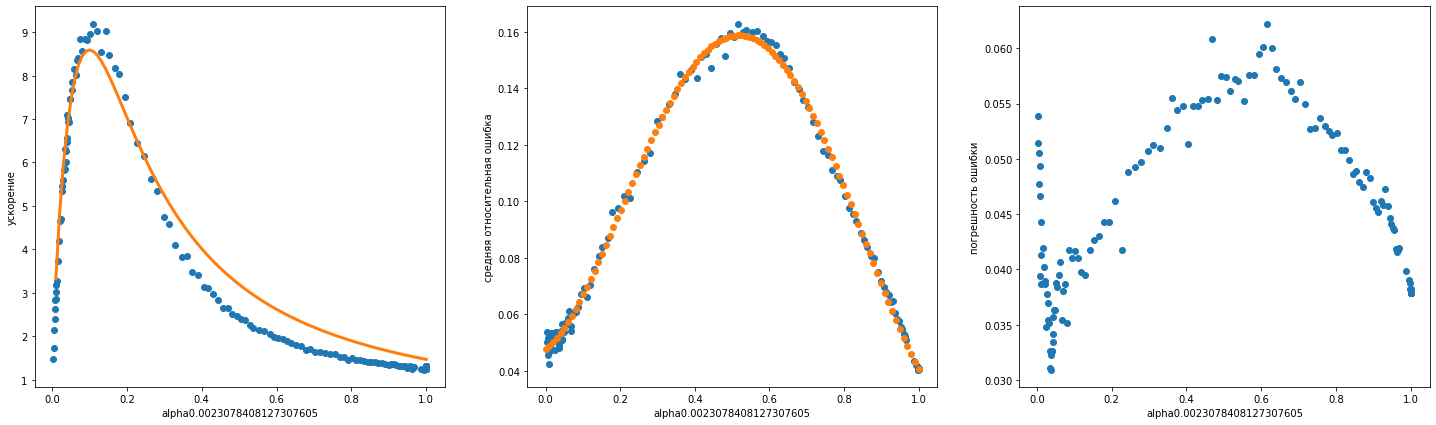

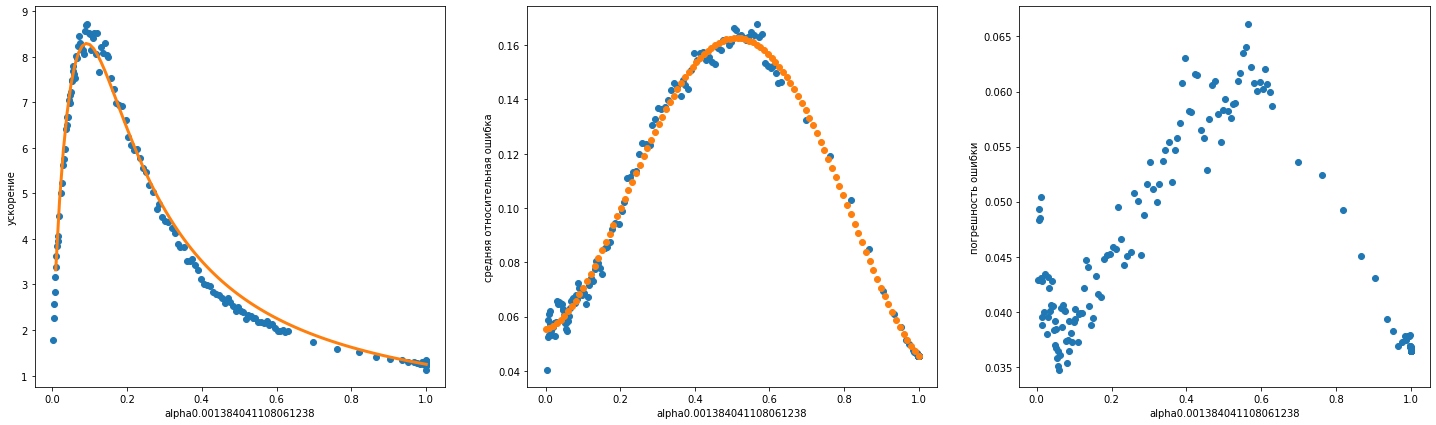

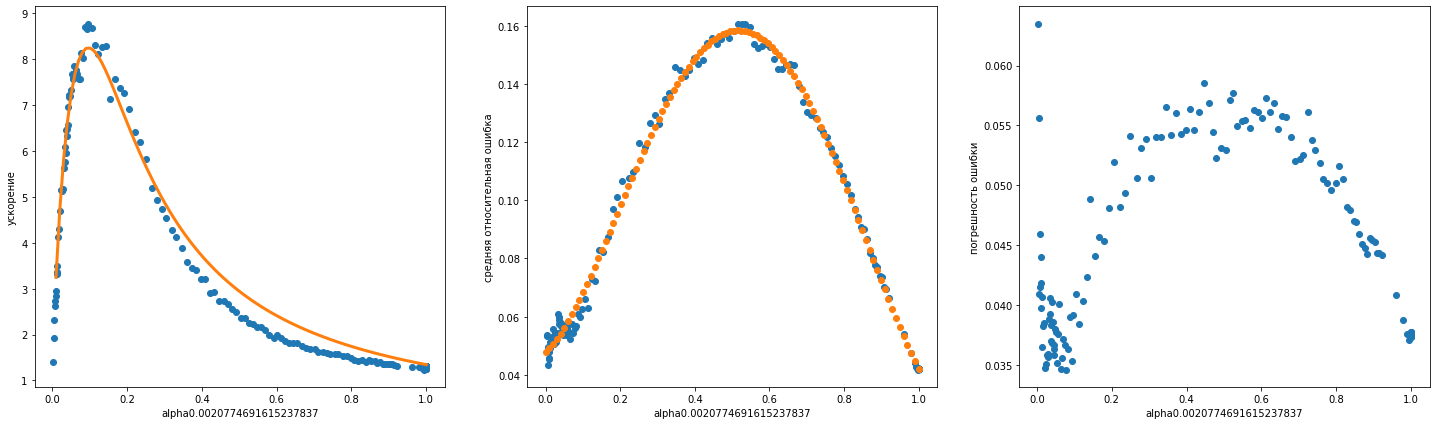

In [15]:
X_max = {}
Y_speedup_max = {}
Y_err_speedup = {}

d=[]
b= []

for name in r:
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs[0].errorbar(X_a[name], Y_speedup[name], fmt='o')
    axs[0].set(xlabel='alpha'+ str(r[name].density), ylabel='ускорение')

    func_r = partial(theory_func, N=r[name].nodes, b0=r[name].density)

    _x = np.array(X_a[name])
    _x = _x[_x < 0.4]
    _xx = np.linspace(0, 1, 100)


    _y = np.array(Y_speedup[name])[0:len(_x)]
    popt = curve_fit(func_r, _x, _y, p0=[0.001, 4])
    func_target = partial(theory_func, c=popt[0][0], g=popt[0][1],N=r[name].nodes, b0=r[name].density)
    a = scipy.optimize.fminbound(lambda x: -func_target(x), 0, 0.5)
    X_max[name] = a
    Y_speedup_max[name] = func_target(a)


    _y = func_target(np.array(_xx))
    axs[0].errorbar(_xx, _y, linewidth=3)

    axs[1].errorbar(X_a[name], Y_err[name], fmt='o')
    axs[1].set(xlabel='alpha' + str(r[name].density), ylabel='средняя относительная ошибка')
    z = np.polyfit(X_a[name], Y_err[name], 4)
    p = np.poly1d(z)
    axs[1].errorbar(_xx, p(_xx), fmt='o')
    Y_err_speedup[name] = p(a)

    print('c={:.2f}'.format(popt[0][0]) +' b={:.2f}'.format(popt[0][1]))
    d.append(r[name].density)
    b.append(popt[0][1])

    axs[2].errorbar(X_a[name], Y_err_std[name], fmt='o')
    axs[2].set(xlabel='alpha'+ str(r[name].density), ylabel='погрешность ошибки')

    # file_name = generate_new_name(name + '.png', 'plots')

    # plt.savefig(file_name)

<ErrorbarContainer object of 3 artists>

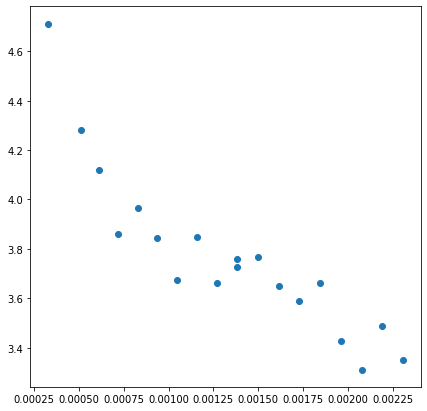

In [16]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(7)
fig.set_figheight(7)

axs.errorbar(d,b , fmt='o')

Построим график ускорения от плотности

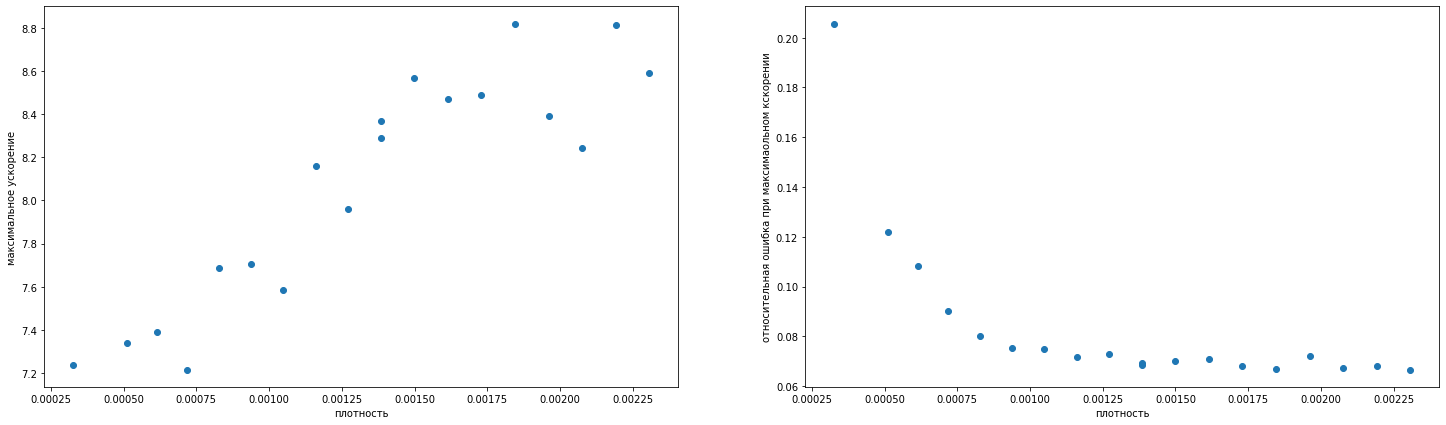

In [7]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(25)
fig.set_figheight(7)


X_betta = [r[n].density for n in r]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')

axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')

plt.show()

In [8]:
def line(x, a,b):
    return a*x + b

def line_predict(x, a,b,alpha, N):
    # print("a:{:.2f} n:{:.2f}".format(alpha, N))
    return a*x/(alpha * (1 + np.log(alpha)/np.log(N))) + b

def inverse(x,a,b):
    return a*(x**-2) + b

Уберем последние 4 точки

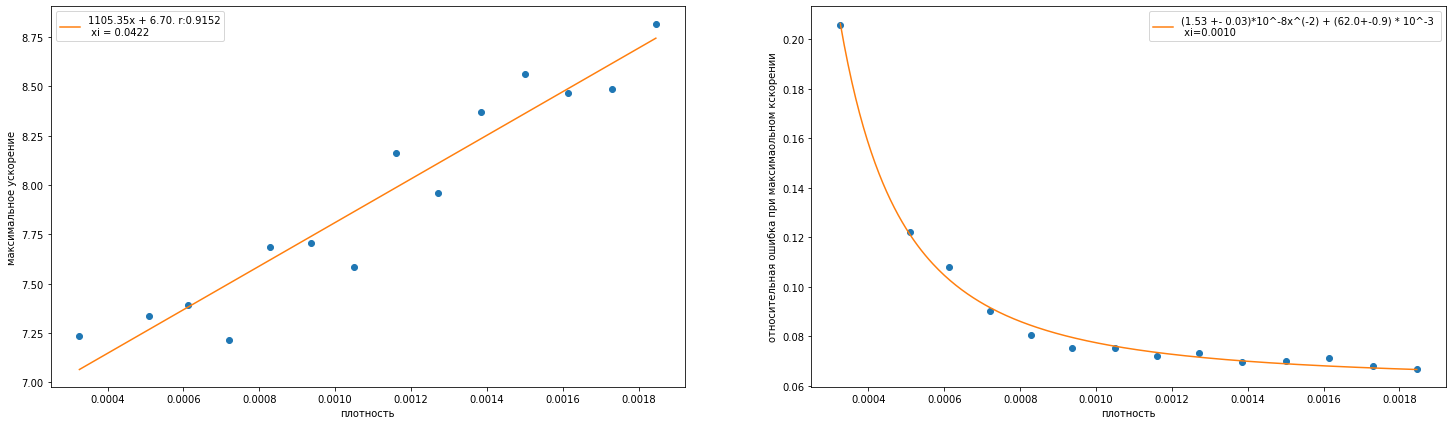

In [9]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(25)
fig.set_figheight(7)

X_max_1 = dict(list(X_max.items())[0:-5])
X_betta = [r[n].density for n in r][0:-5]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max][0:-5]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup][0:-5]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_betta,Y_betta_speedup)

_x = np.linspace(min(X_betta), max(X_betta))
_y = slope * _x + intercept

y_obs = Y_betta_speedup
y_exp = slope * np.array(X_betta) + intercept

axs[0].errorbar(_x, _y,label = '{:.2f}x + {:.2f}. r:{:.4f}\n xi = {:.4f}'.format(slope,intercept, r_value**2,scipy.stats.chisquare(y_obs, y_exp)[0] ))
axs[0].legend()


axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')

popt = curve_fit(inverse, X_betta, Y_betta_err, p0=[0.000000015,0.06])
_xx = np.linspace(min(X_betta), max(X_betta), 300)
_yy = inverse(_xx, *popt[0])
y_obs = Y_betta_err
y_exp = inverse(np.array(X_betta), *popt[0])
axs[1].errorbar(_xx, _yy,label = '({:.2f} +- {:.2f})*10^-8x^(-2) + ({:.1f}+-{:.1f}) * 10^-3 \n xi={:.4f}'.format(popt[0][0]*10**8,np.sqrt(popt[1][0][0])*10**8,popt[0][1] * 10**3, np.sqrt(popt[1][1][1]) * 10**3, scipy.stats.chisquare(y_obs, y_exp)[0]))
axs[1].legend()
plt.show()

In [10]:
from graph_generator import get_graph

H = get_graph('R2555133')


In [11]:
print(2*len(H.edges)/(len(H.nodes) * (len(H.nodes) - 1
                                      )))

0.00017014188633679447
